# Model

### Imports

In [73]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from typing import Tuple


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import (
    RandomForestRegressor,
    VotingRegressor,
    AdaBoostRegressor,
    GradientBoostingRegressor,
    StackingRegressor,
    ExtraTreesRegressor,
)

from xgboost import XGBRegressor

In [74]:
SEED = 42
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 3)
np.random.seed(SEED)

In [75]:
X_train = pd.read_csv("train_clean.csv", index_col=False, delimiter=";")
X_test = pd.read_csv("test_clean.csv", index_col=False, delimiter=";")

In [76]:
X = X_train.loc[:, X_train.columns != "weekly_demand"]
y = X_train["weekly_demand"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=SEED)

results = pd.DataFrame(columns=["MSE"])

### Simple XGBoost

In [77]:
xgboost_default = XGBRegressor()
xgboost_default.fit(X_train, y_train)

y_pred = xgboost_default.predict(X_val)
results.loc["XGBoost-default", :] = [np.log10(mean_squared_error(y_pred, y_val))]

results.sort_values(by="MSE", ascending=True)

,MSE
XGBoost-default,7.72


### Feature importance

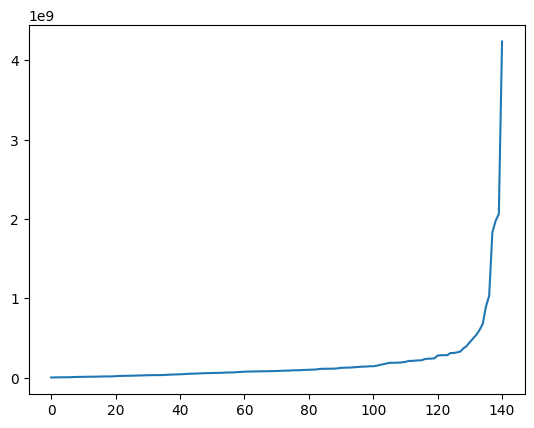

In [78]:
feature_importance = xgboost_default.get_booster().get_score(importance_type="gain")
sorted_features = dict(sorted(feature_importance.items(), key=lambda item: item[1]))

plt.plot(range(len(sorted_features)), list(sorted_features.values()))

In [83]:
n = len(sorted_features) // 4
keep_columns = list(sorted_features.keys())[3*n:]

In [84]:
X_train = pd.read_csv("train_clean.csv", index_col=False, delimiter=";")
X_test = pd.read_csv("test_clean.csv", index_col=False, delimiter=";")

keep_columns.append("ID")
X_test = X_test[keep_columns]
keep_columns.append("weekly_demand")
X_train = X_train[keep_columns]

X = X_train.loc[:, X_train.columns != "weekly_demand"]
y = X_train["weekly_demand"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [85]:
xgboost_features = XGBRegressor()
xgboost_features.fit(X_train, y_train)

y_pred = xgboost_features.predict(X_val)
results.loc["XGBoost-features", :] = [np.log10(mean_squared_error(y_pred, y_val))]

results.sort_values(by="MSE", ascending=True)

,MSE
XGBoost-features,7.714
XGBoost-default,7.72


## Submit

In [91]:
y_pred = xgboost_features.predict(X_test)
submission = pd.DataFrame(zip(X_test["ID"], y_pred), columns=["ID", "Production"])
submission

,ID,Production
0,90,3481.497
1,16,6079.897
2,65,6466.152
3,138,1320.683
4,166,401.498
...,...,...
2245,12697,21929.059
2246,12742,7804.158
2247,12714,9482.833
2248,12762,5516.167


In [93]:
def funcio(x): return x * 1.1

submission["Production"] = submission["Production"].map(funcio)

In [ ]:
submission.to_csv("submission14.csv")